2024-05-14 02:45:28,971 [torchrl][INFO] check_env_specs succeeded!


cuda:0


tensordict_data: TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([60, 100, 2, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([60, 100, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                info: TensorDict(
                    fields={
                        agent_collisions: Tensor(shape=torch.Size([60, 100, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                        final_rew: Tensor(shape=torch.Size([60, 100, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                        pos_rew: Tensor(shape=torch.Size([60, 100, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True)},
                    batch_size=torch.Size([60, 100, 2]),
                    device=cuda:0,
                    is_shared=True),
                observation: Tensor(shape=torch.Size([60, 100, 2, 18]), dev

episode_reward_mean = 0:   0%|          | 0/60000 [00:08<?, ?it/s]

tensordict_data: TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([60, 100, 2, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([60, 100, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                info: TensorDict(
                    fields={
                        agent_collisions: Tensor(shape=torch.Size([60, 100, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                        final_rew: Tensor(shape=torch.Size([60, 100, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                        pos_rew: Tensor(shape=torch.Size([60, 100, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True)},
                    batch_size=torch.Size([60, 100, 2]),
                    device=cuda:0,
                    is_shared=True),
                observation: Tensor(shape=torch.Size([60, 100, 2, 18]), dev

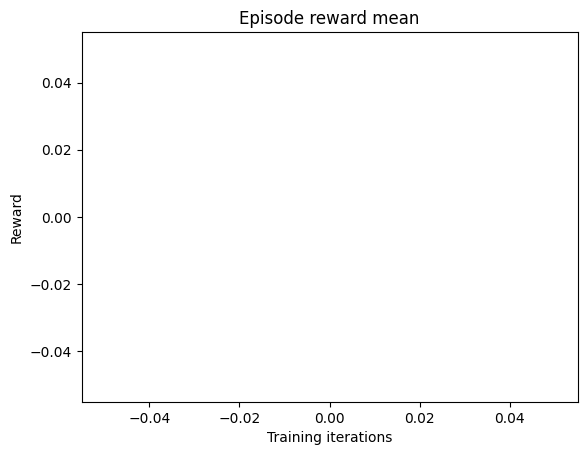

In [12]:
import torch
import multiprocessing
from torchrl.envs.libs.vmas import VmasEnv
from tensordict.nn import TensorDictModule
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import RewardSum, TransformedEnv
from torchrl.envs.utils import check_env_specs
from torchrl.modules import MultiAgentMLP, ProbabilisticActor, TanhNormal
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
import PIL.Image as PILImage
from IPython.display import display, Image
import numpy as np


class QNetwork(torch.nn.Module):
    def __init__(
        self,
        observation_shape,
        action_shape,
        n_agents,
        device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    ):
        super(QNetwork, self).__init__()

        self.q_net = MultiAgentMLP(
            n_agent_inputs=observation_shape + action_shape,
            n_agent_outputs=1,
            n_agents=n_agents,
            centralised=False,
            share_params=True,
            device=device,
            depth=depth,
            num_cells=num_cells,
            activation_class=activation_class,
        )

    def forward(self, observation, action):
        q_value = self.q_net(torch.cat([observation, action], dim=-1))
        return q_value


class QLearningLoss:
    def __init__(self, q_network, optimizer, gamma):
        self.q_network = q_network
        self.optimizer = optimizer
        self.gamma = gamma

    def calculate_and_optimize_loss(self, subdata):
        observation = subdata.get(("agents", "observation"))
        action = subdata.get(("agents", "action"))
        reward = subdata.get(("agents", "reward"))
        next_observation = subdata.get(("next", "agents", "observation"))
        done = subdata.get(("next", "agents", "done"))

        current_q = self.q_network(observation, action)
        with torch.no_grad():
            next_q = self.q_network(next_observation, action)
            target_q = reward + (1 - done) * self.gamma * next_q

        loss_value = torch.nn.functional.mse_loss(current_q, target_q)

        self.optimizer.zero_grad()
        loss_value.backward()
        self.optimizer.step()

        return loss_value


class QLearningTrainer:
    def __init__(
        self,
        q_network,
        replay_buffer,
        optimizer,
        loss_module,
        collector,
        num_epochs,
        minibatch_size,
        frames_per_batch,
        device,
        total_frames,
        gamma,
        env,
        visualization_handler=None,
    ):
        self.q_network = q_network
        self.replay_buffer = replay_buffer
        self.optimizer = optimizer
        self.loss_module = loss_module
        self.collector = collector
        self.num_epochs = num_epochs
        self.minibatch_size = minibatch_size
        self.frames_per_batch = frames_per_batch
        self.device = device
        self.total_frames = total_frames
        self.gamma = gamma
        self.env = env
        self.visualization_handler = visualization_handler

    def train(self, max_steps):
        pbar = tqdm(total=self.total_frames, desc="episode_reward_mean = 0")
        episode_reward_mean_list = []

        for tensordict_data in self.collector:
            print("tensordict_data:", tensordict_data)  # Print statement added
            
            if ("next", "agents", "done") not in tensordict_data.keys(include_nested=True):
                # If "done" key is missing, set it to a tensor of all False
                done = torch.zeros_like(tensordict_data.get(("next", "agents", "episode_reward")), dtype=torch.bool)
            else:
                done = tensordict_data.get(("next", "agents", "done"))
                
            episode_reward = tensordict_data.get(("next", "agents", "episode_reward"))

            # Ensure episode_reward[done] has the same batch size as done
            episode_reward_done = episode_reward.squeeze(3)[done.squeeze(3)]
            
            # Check if episode_reward_done is not empty before setting it
            if episode_reward_done.numel() > 0:
                tensordict_data.set(
                    ("agents", "reward"),
                    episode_reward_done,
                )
                data_view = tensordict_data.reshape(-1)
                self.replay_buffer.extend(data_view)

                for _ in range(self.num_epochs):
                    for _ in range(self.frames_per_batch // self.minibatch_size):
                        subdata = self.replay_buffer.sample()
                        loss_value = self.loss_module.calculate_and_optimize_loss(subdata)

                done = tensordict_data.get(("next", "agents", "done"))
                episode_reward_mean = (
                    tensordict_data.get(("next", "agents", "episode_reward"))[done].mean().item()
                )
                episode_reward_mean_list.append(episode_reward_mean)
                pbar.set_description(f"episode_reward_mean = {episode_reward_mean}", refresh=True)
                pbar.update(self.frames_per_batch)

                if self.visualization_handler is not None:
                    self.visualization_handler.render_and_save_gif(self.env, self.q_network, max_steps)
            else:
                print("No episode_reward_done data found")
        

        pbar.close()
        return episode_reward_mean_list




def main():
    torch.manual_seed(0)
    is_fork = multiprocessing.get_start_method() == "fork"
    device = (
        torch.device(0)
        if torch.cuda.is_available() and not is_fork
        else torch.device("cpu")
    )
    vmas_device = device
    print(vmas_device)

    # Sampling
    frames_per_batch = 6_000
    n_iters = 10
    total_frames = frames_per_batch * n_iters

    # Training
    num_epochs = 1
    minibatch_size = 400
    lr = 0.0003
    gamma = 0.9

    max_steps = 100
    num_vmas_envs = frames_per_batch // max_steps
    scenario_name = "navigation"
    n_agents = 2

    env = VmasEnv(
        scenario=scenario_name,
        num_envs=num_vmas_envs,
        continuous_actions=True,
        max_steps=max_steps,
        device=device,
        n_agents=n_agents,
    )

    env = TransformedEnv(
        env,
        RewardSum(in_keys=[env.reward_key], out_keys=[("agents", "episode_reward")]),
    )

    check_env_specs(env)

    q_network = QNetwork(
        observation_shape=env.observation_spec["agents", "observation"].shape[-1],
        action_shape=env.action_spec.shape[-1],
        n_agents=env.n_agents,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    )

    q_optimizer = torch.optim.Adam(q_network.parameters(), lr=lr)

    q_learning_loss = QLearningLoss(q_network=q_network, optimizer=q_optimizer, gamma=gamma)

    collector = SyncDataCollector(
        env,
        policy=None,  # Not needed for Q-learning
        device=vmas_device,
        storing_device=device,
        frames_per_batch=frames_per_batch,
        total_frames=total_frames,
    )

    replay_buffer = ReplayBuffer(
        storage=LazyTensorStorage(frames_per_batch, device=device),
        sampler=SamplerWithoutReplacement(),
        batch_size=minibatch_size,
    )

    gif_path = f"{scenario_name}.gif"
    visualization_handler = None  # No visualization needed for Q-learning

    q_learning_trainer = QLearningTrainer(
        q_network=q_network,
        replay_buffer=replay_buffer,
        optimizer=q_optimizer,
        loss_module=q_learning_loss,
        collector=collector,
        num_epochs=num_epochs,
        minibatch_size=minibatch_size,
        frames_per_batch=frames_per_batch,
        device=device,
        total_frames=total_frames,
        gamma=gamma,
        env=env,
        visualization_handler=visualization_handler,
    )

    episode_reward_mean_list = q_learning_trainer.train(max_steps)

    plt.plot(episode_reward_mean_list)
    plt.xlabel("Training iterations")
    plt.ylabel("Reward")
    plt.title("Episode reward mean")
    plt.show()


if __name__ == "__main__":
    main()
